This notebook perform some analysis on several CLIP models fine-tuned on TinyImageNet. 

## Setup Environment

In [1]:
LOCAL = True

# if run locally:
if LOCAL:
    DATA_DIR = "../dataset"
    CODE_DIR = "../"
# on Colab
else:
    DATA_DIR = "/content"
    CODE_DIR = "./clip_TinyImageNet"

By default, We will work under the same dir as this notebook

In [2]:
import os, sys
ROOT = os.path.abspath(CODE_DIR)
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

If you want to use Claude Code, uncomment the cell below.

In [3]:
# !npm install -g @anthropic-ai/claude-code

If use Colab, you need to save output results to google drive.

In [4]:
if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')
    storage_dir = "drive/MyDrive/Colab Notebooks/"

To copy the code for fine-tuneing clip on tinyImageNet, run:

In [5]:
if not LOCAL:
    !git clone https://github.com/nbzy1995/clip_TinyImageNet.git

Now we download tiny imagenet dataset. The cell below will create a directory called "tiny-imagenet-200" containing the dataset.

In [6]:
if not LOCAL:
    !wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -q tiny-imagenet-200.zip

We now copy pre-computed index for the train/ folder, 90% for training, 10% for validation. The val/ folder will be used as test set.

In [7]:
if not LOCAL:
    !cp $CODE_DIR/dataset/tiny_imagenet_train_val_indices.npy /content/tiny_imagenet_train_val_indices.npy

Python Requirements for fine-tuning clip on tinyImageNet

In [8]:
if not LOCAL:
    !pip install --quiet --upgrade pip
    !pip install -q -r clip_TinyImageNet/requirements.txt
    print("✅ Core packages installed!")

Device Info


In [9]:
import torch
import subprocess

print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU deivce: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("❌ No GPU available! Please enable GPU runtime in Colab.")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

🔍 System Information:
Python version: Python 3.11.5
PyTorch version: 2.8.0
CUDA available: False
❌ No GPU available! Please enable GPU runtime in Colab.
Runtime > Change runtime type > Hardware accelerator > GPU


## Load Models and Dataset
Load several models (different fine-tunes), at various epochs

In [10]:
import torch
import clip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import tqdm
from utils import ModelWrapper,get_model_from_sd, eval_model_on_dataset

In [11]:
# Load all trained model_sds

Model_names = ['config1', 'config2', 'config3', 'config4', 'config5']
Model_sds = []
checkpoint_steps = range(0, 11, 1)

Base_model, preprocess = clip.load('ViT-B/32', DEVICE, jit=False)
Base_model = Base_model.float() # Force the base model to stay in float32 to match saved weights

for name in Model_names:
    for checkpoint_step in checkpoint_steps:

        model_path = f'checkpoints/{name}_{checkpoint_step}.pt'
        drive_path = f'/content/drive/MyDrive/Colab Notebooks/{model_path}'

        # Try local first, then Drive backup
        sd = None
        if os.path.exists(model_path):
            print(f'Loading {model_path} (local)')
            sd = torch.load(model_path, map_location=DEVICE)
        elif os.path.exists(drive_path):
            print(f'Loading {drive_path} (from Drive)')
            sd = torch.load(drive_path, map_location=DEVICE)
        
        if sd:
            Model_sds.append({
                'name': name,
                'epoch': checkpoint_step,
                'state_dict': sd
            })

print(f"✅ Loaded {len(Model_sds)} model_sds successfully!")

Loading checkpoints/config3_6.pt (local)
Loading checkpoints/config4_6.pt (local)
Loading checkpoints/config5_9.pt (local)
✅ Loaded 3 model_sds successfully!


In [ ]:
print("Creating datasets...")

from dataset.tiny_imagenet import TinyImageNet
from torch.utils.data import Subset

# Use CLIP's expected preprocessing for proper model evaluation
import clip
clip_preprocess = clip.load('ViT-B/32', DEVICE, jit=False)[1]

data_tinyImageNet = TinyImageNet(
    train_preprocess=clip_preprocess,  # Use CLIP preprocessing for training
    eval_preprocess=clip_preprocess,   # Use CLIP preprocessing for evaluation
    location=DATA_DIR,
    batch_size=32,
    num_workers=2,
    distributed=False,
)

# For local testing, let's use a small subset of the test data
if LOCAL:
    subset_fraction = 0.05 # Use 5% of the test data
    num_samples = int(len(data_tinyImageNet.test_dataset) * subset_fraction)
    subset_indices = list(range(num_samples))
    test_subset = Subset(data_tinyImageNet.test_dataset, subset_indices)
    
    Test_loader = torch.utils.data.DataLoader(
        test_subset,
        batch_size=data_tinyImageNet.batch_size,
        num_workers=data_tinyImageNet.num_workers
    )
    print(f"🧪 Using a subset of the test data for local run: {len(test_subset)} samples.")
else:
    Test_loader = data_tinyImageNet.test_loader
    print("✅ Using the full test dataset.")


Creating datasets...
🧪 Using a subset of the test data for local run: 500 samples.


## Parameter space distance - pairs of models

Pairs: At any two config, each at any epoch, 

Compute L2 distance, over all pairs of models

In [13]:
n_models = len(Model_sds)
print(f"🔍 Analyzing {n_models} models")

# Get all parameter group names from first model
param_names = list(Model_sds[0]['state_dict'].keys())
print(f"Total parameter groups: {len(param_names)}")

# Separate classification head vs backbone parameters
head_params = [k for k in param_names if k.startswith('classification_head')]
backbone_params = [k for k in param_names if not k.startswith('classification_head')]

print(f"Classification head parameter groups: {len(head_params)}")
print(f"Backbone parameter groups: {len(backbone_params)}")

# Check if backbone parameters are identical
backbone_identical = True
for param_name in backbone_params:
    ref_param = Model_sds[0]['state_dict'][param_name]
    for i in range(1, n_models):
        if not torch.allclose(ref_param, Model_sds[i]['state_dict'][param_name], atol=1e-6):
            # print(f"❌ {param_name} differs between model 0 and model {i}")
            backbone_identical = False
            break

if backbone_identical:
    print("✅ All backbone parameters are identical across models!")
else:
    print("❌ Some backbone parameters differ between models.")

records = []

for i in range(n_models):
    for j in range(i + 1, n_models):
        model_i = Model_sds[i]
        model_j = Model_sds[j]

        # Flatten and concatenate all parameters
        params_i = torch.cat([p.flatten() for p in model_i['state_dict'].values()])
        params_j = torch.cat([p.flatten() for p in model_j['state_dict'].values()])

        # Compute L2 distance
        l2_dist = torch.norm(params_i - params_j).item()

        records.append({
            'model1_name': model_i['name'],
            'model1_epoch': model_i['epoch'],
            'model2_name': model_j['name'],
            'model2_epoch': model_j['epoch'],
            'l2_distance': l2_dist,
        })

# Create DataFrame
df_results = pd.DataFrame(records)
print("✅ DataFrame with L2 distances created.")
df_results.head()

🔍 Analyzing 3 models
Total parameter groups: 160
Classification head parameter groups: 2
Backbone parameter groups: 158
❌ Some backbone parameters differ between models.
✅ DataFrame with L2 distances created.


,model1_name,model1_epoch,model2_name,model2_epoch,l2_distance
0,config3,6,config4,6,6.266105
1,config3,6,config5,9,1.097487
2,config4,6,config5,9,6.281423


### Plot: distance(epoch)
L2 distance between any two different models at same epoch during training.

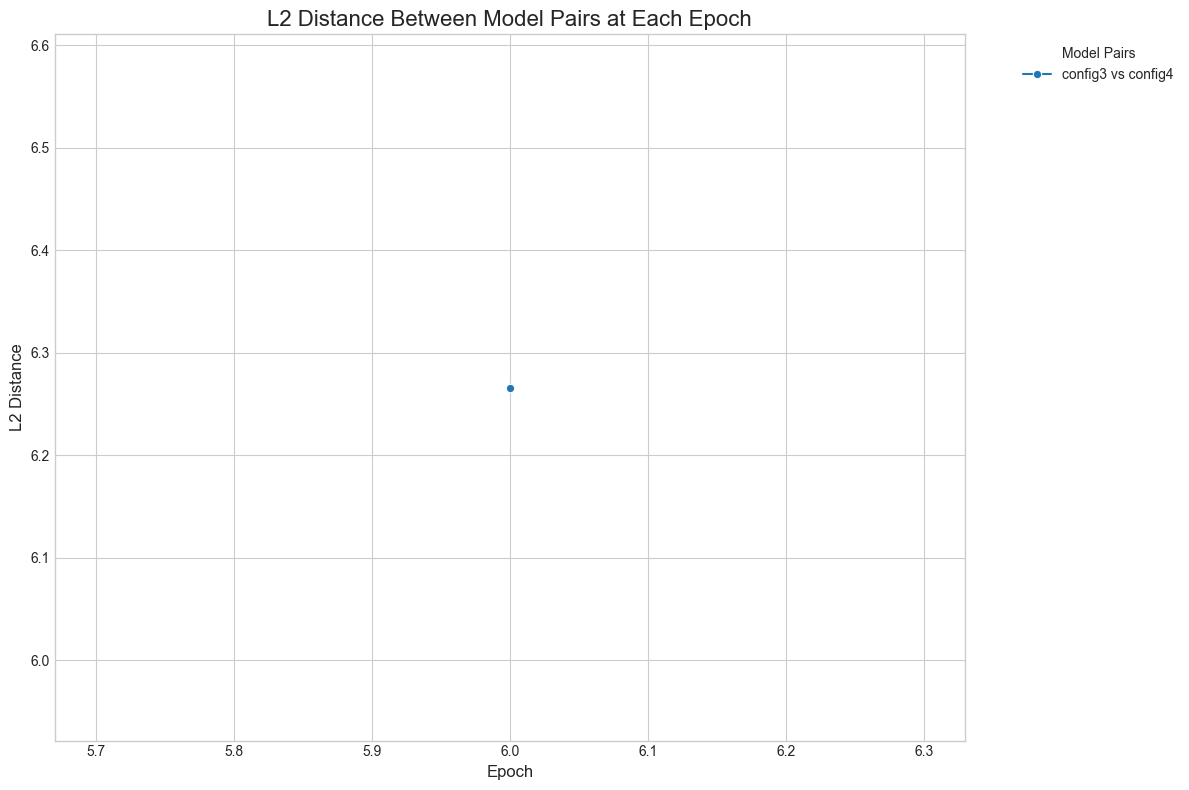

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for pairs of different models at the same epoch
same_epoch_df = df_results[df_results['model1_epoch'] == df_results['model2_epoch']].copy()
same_epoch_df['model_pair'] = same_epoch_df.apply(lambda r: f"{r['model1_name']} vs {r['model2_name']}", axis=1)

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='l2_distance',
    hue='model_pair',
    marker='o',
    ax=ax
)

ax.set_title('L2 Distance Between Model Pairs at Each Epoch', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('L2 Distance', fontsize=12)
ax.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

## Model soup performance (on test split) -  pairs of models

### Individual Model Performance

In [15]:
# Evaluate each individual model at each epoch. 
individual_accuracies = []
for model_info in tqdm(Model_sds, desc="Evaluating Individual Models"):
    model = get_model_from_sd(model_info['state_dict'], Base_model)
    acc = eval_model_on_dataset(model, Test_loader)
    individual_accuracies.append({
        'name': model_info['name'],
        'epoch': model_info['epoch'],
        'accuracy': acc
    })

df_individual_acc = pd.DataFrame(individual_accuracies)
print("✅ Individual model accuracies calculated.")
df_individual_acc.head()



Evaluating Individual Models:   0%|          | 0/3 [00:00<?, ?it/s]

[0% 0/8]	Acc: 73.44	Data (t) 2.625	Batch (t) 3.353
[0% 0/8]	Acc: 79.69	Data (t) 2.381	Batch (t) 3.000
[0% 0/8]	Acc: 73.44	Data (t) 2.385	Batch (t) 3.024
✅ Individual model accuracies calculated.


,name,epoch,accuracy
0,config3,6,0.780
1,config4,6,0.808
2,config5,9,0.750


In [18]:
# Merge individual accuracies into the main DataFrame
df_results = df_results.merge(
    df_individual_acc,
    left_on=['model1_name', 'model1_epoch'],
    right_on=['name', 'epoch']
).rename(columns={'accuracy': 'model1_accuracy'}).drop(columns=['name', 'epoch'])

df_results = df_results.merge(
    df_individual_acc,
    left_on=['model2_name', 'model2_epoch'],
    right_on=['name', 'epoch']
).rename(columns={'accuracy': 'model2_accuracy'}).drop(columns=['name', 'epoch'])

# Calculate mean accuracy
df_results['mean_accuracy'] = (df_results['model1_accuracy'] + df_results['model2_accuracy']) / 2
print("✅ Individual accuracies merged and mean accuracy calculated.")
df_results.head()

✅ Individual accuracies merged and mean accuracy calculated.


,model1_name,model1_epoch,model2_name,model2_epoch,l2_distance,soup_accuracy,model1_accuracy,model2_accuracy,mean_accuracy
0,config3,6,config4,6,6.266105,0.808,0.780,0.808,0.794
1,config3,6,config5,9,1.097487,0.778,0.780,0.750,0.765
2,config4,6,config5,9,6.281423,0.802,0.808,0.750,0.779


Compute soup accuracy for each pair

In [19]:
def create_soup(state_dicts, weights=None):
    """Create a model soup by averaging state dicts with given weights"""
    if weights is None:
        weights = [1.0 / len(state_dicts)] * len(state_dicts)

    # Start with the first model weighted
    soup_state_dict = {k: v.clone() * weights[0] for k, v in state_dicts[0].items()}

    # Add remaining models
    for i, state_dict in enumerate(state_dicts[1:], 1):
        for k, v in state_dict.items():
            soup_state_dict[k] += v.clone() * weights[i]

    return soup_state_dict


In [ ]:

soup_accuracies = []
model_map = {(m['name'], m['epoch']): m['state_dict'] for m in Model_sds}

for _, row in tqdm(df_results.iterrows(), total=len(df_results), desc="Evaluating Soups"):
    sd1 = model_map[(row['model1_name'], row['model1_epoch'])]
    sd2 = model_map[(row['model2_name'], row['model2_epoch'])]
    
    # Create a soup model:  theta = 1/2(theta_i + theta_j)
    soup_sd = create_soup([sd1, sd2])
    
    # Evaluate the soup on test split
    soup_model = get_model_from_sd(soup_sd, Base_model)
    acc = eval_model_on_dataset(soup_model, Test_loader)
    soup_accuracies.append(acc)


Evaluating Soups:   0%|          | 0/3 [00:00<?, ?it/s]

[0% 0/8]	Acc: 76.56	Data (t) 2.705	Batch (t) 3.500
[0% 0/8]	Acc: 75.00	Data (t) 2.319	Batch (t) 2.947
[0% 0/8]	Acc: 76.56	Data (t) 3.582	Batch (t) 4.652


KeyError: 'mean_accuracy'

In [20]:
df_results['soup_accuracy'] = soup_accuracies

# Calculate mean accuracy and soup improvement
df_results['soup_improvement'] = df_results['soup_accuracy'] - df_results['mean_accuracy']

print("✅ Soup accuracies calculated and added to DataFrame.")
df_results.head()

✅ Soup accuracies calculated and added to DataFrame.


,model1_name,model1_epoch,model2_name,model2_epoch,l2_distance,soup_accuracy,model1_accuracy,model2_accuracy,mean_accuracy,soup_improvement
0,config3,6,config4,6,6.266105,0.808,0.780,0.808,0.794,0.014
1,config3,6,config5,9,1.097487,0.778,0.780,0.750,0.765,0.013
2,config4,6,config5,9,6.281423,0.802,0.808,0.750,0.779,0.023


### Plot: soup accuracy(epoch)
soup accuracy for any two models at same epoch.

soup improvement above mean of each model.

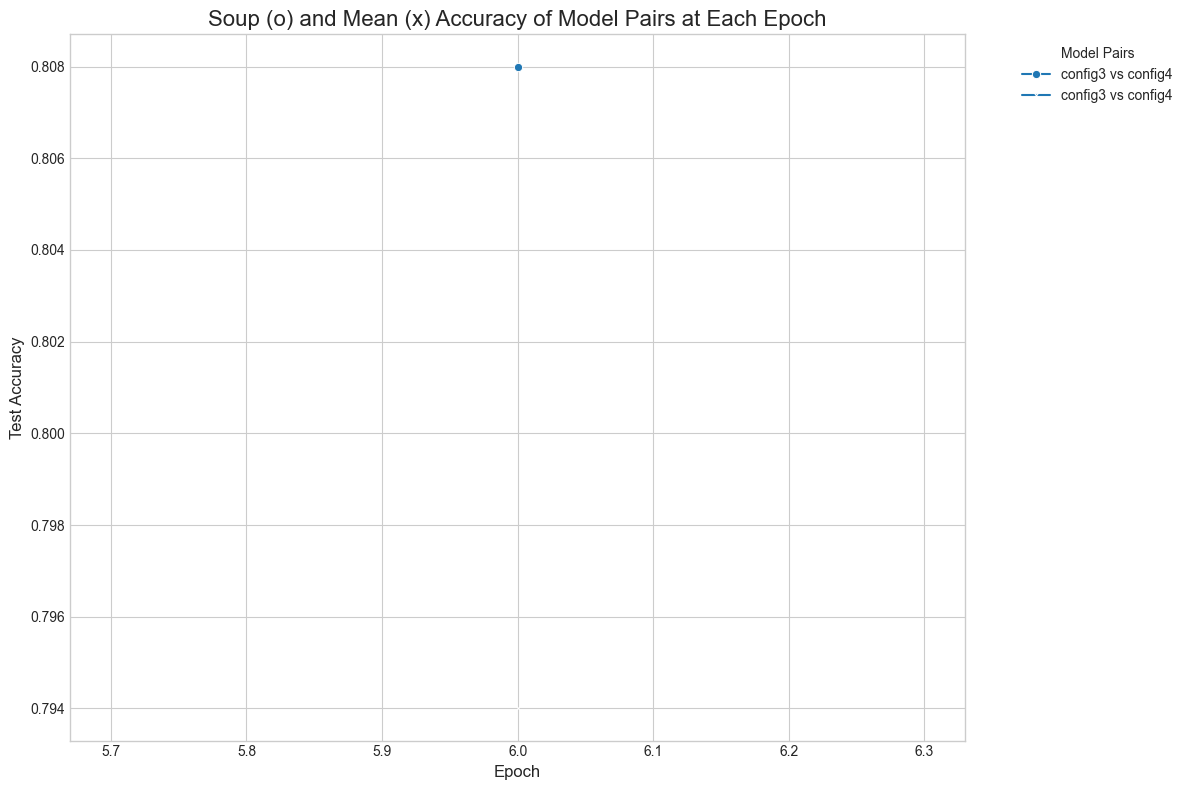

In [21]:
# Filter for pairs of different models at the same epoch
same_epoch_df = df_results[df_results['model1_epoch'] == df_results['model2_epoch']].copy()
same_epoch_df['model_pair'] = same_epoch_df.apply(lambda r: f"{r['model1_name']} vs {r['model2_name']}", axis=1)

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='soup_accuracy',
    hue='model_pair',
    marker='o',
    ax=ax
)
sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='mean_accuracy',
    hue='model_pair',
    marker='x',
    ax=ax
)

ax.set_title('Soup (o) and Mean (x) Accuracy of Model Pairs at Each Epoch', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

## Relation between Soup performance and model L2 distance

### Plot: soup improvement vs L2 distance

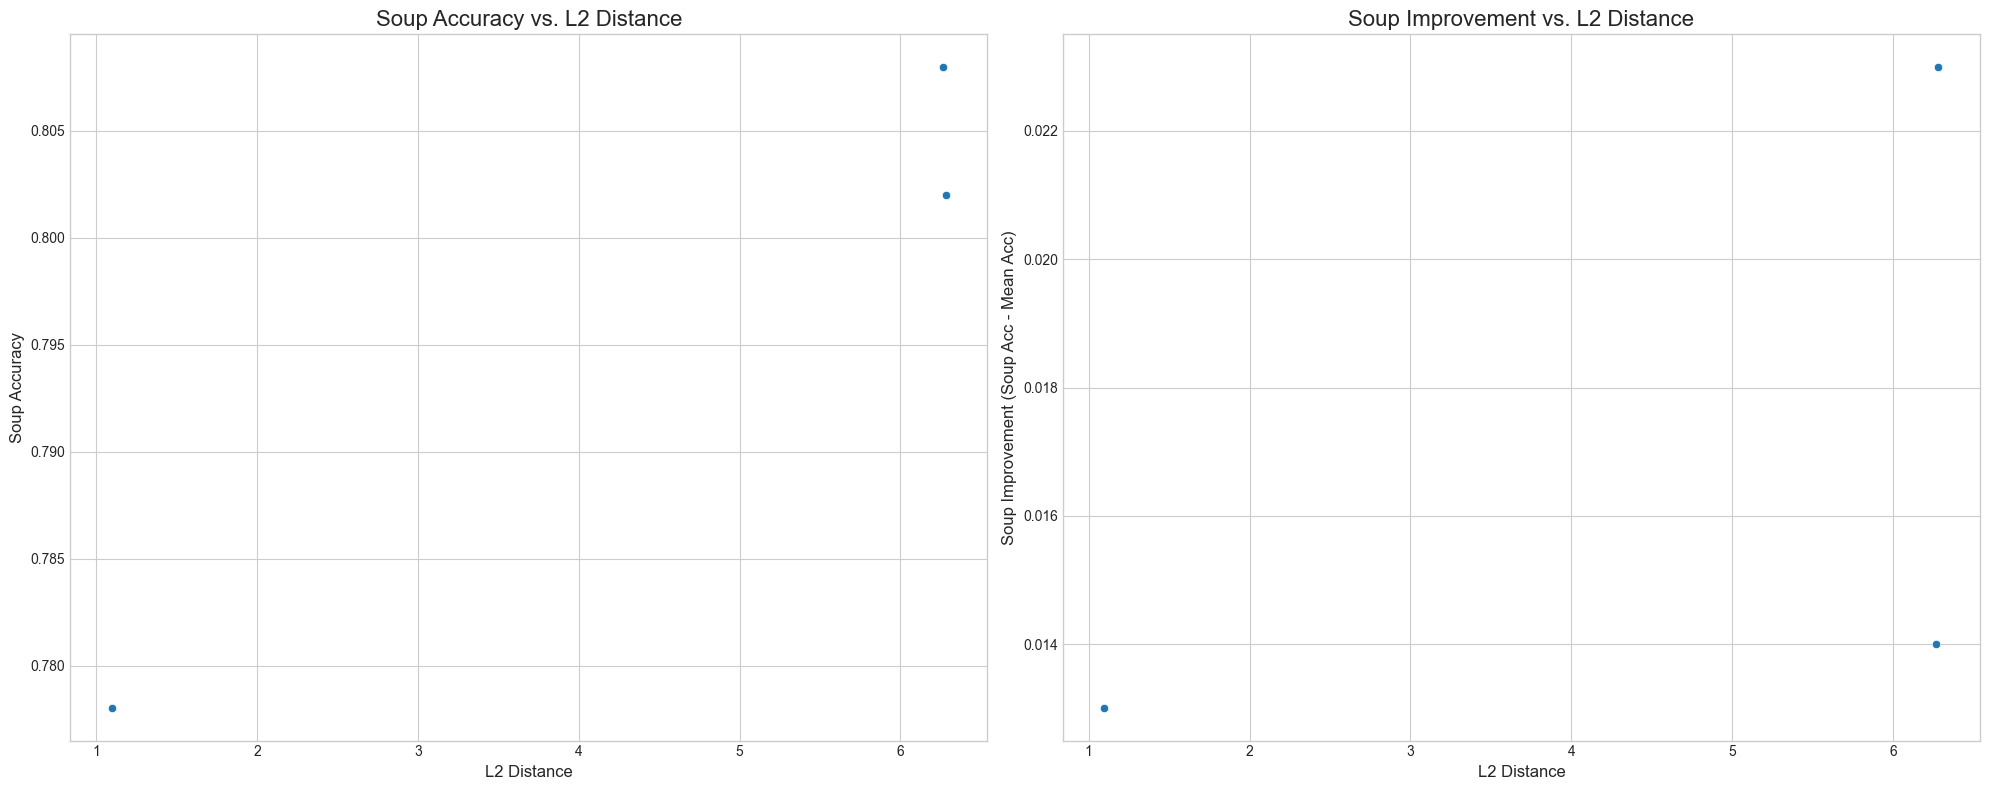

In [24]:
# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Soup Accuracy vs. L2 Distance
sns.scatterplot(
    data=df_results,
    x='l2_distance',
    y='soup_accuracy',
    ax=axes[0]
)
axes[0].set_title('Soup Accuracy vs. L2 Distance', fontsize=16)
axes[0].set_xlabel('L2 Distance', fontsize=12)
axes[0].set_ylabel('Soup Accuracy', fontsize=12)

# Plot 2: Soup Improvement vs. L2 Distance
sns.scatterplot(
    data=df_results,
    x='l2_distance',
    y='soup_improvement',
    ax=axes[1]
)
axes[1].set_title('Soup Improvement vs. L2 Distance', fontsize=16)
axes[1].set_xlabel('L2 Distance', fontsize=12)
axes[1].set_ylabel('Soup Improvement (Soup Acc - Mean Acc)', fontsize=12)

plt.tight_layout()
plt.show()